### Importing the libraries

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from math import *
import os

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import feature_extraction, model_selection
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Encoders
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder()
label_binarizer = LabelBinarizer()

### Collecting the data

###### Reading the dataset

In [2]:
cora_features = [f"word_{i}" for i in range(1433)] # Feature names for the columns
cora_content = pd.read_csv("cora.content", sep="\t", names=["Id", *cora_features, "Class"]).set_index("Id")
cora_cities = pd.read_csv("cora.cites", names=["target", "source"], sep="\t")
cora_content_data = cora_content.drop(["Class"], axis=1)
cora_class = cora_content["Class"]

###### Pre-processing the data

In [3]:
# Labeling the data

label_enc_class = label_encoder.fit_transform(y=cora_class)
onehot_enc_class = onehot_encoder.fit_transform(label_enc_class.reshape(len(label_enc_class),1)).toarray()

In [4]:
y_classes = list(label_encoder.classes_)
y = pd.DataFrame(data=onehot_enc_class, columns=y_classes)

for i in y_classes:
    cora_content_data[i] = list(y[i])

In [5]:
y

,Case_Based,Genetic_Algorithms,Neural_Networks,Probabilistic_Methods,Reinforcement_Learning,Rule_Learning,Theory
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2703,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2704,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2705,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2706,1.0,0.0,0.0,0.0,0.0,0.0,0.0


###### Creating the Stellargraph:

In [6]:
cora_graph = StellarGraph({"paper": cora_content_data} ,{"cites": cora_cities})
print(cora_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


### Class Prediction:

In [7]:
# Splitting the dataset: 
train_data, val_data = train_test_split(cora_content, train_size=200, random_state=5, test_size=None)
val_data, test_data = train_test_split(val_data, train_size=700, random_state=5, test_size=None)

# Inputs:
train_x = train_data.index
test_x = test_data.index
val_x = val_data.index

# Outputs:
train_y = label_binarizer.fit_transform(train_data["Class"])
val_y = label_binarizer.fit_transform(val_data["Class"])
test_y = label_binarizer.fit_transform(test_data["Class"])

###### Generator creation

In [8]:
generator = FullBatchNodeGenerator(cora_graph, method="gat")
train_gen = generator.flow(train_x, train_y)
val_gen = generator.flow(val_x, val_y)
test_gen = generator.flow(test_x, test_y)

###### GAT model:

In [9]:
gat = GAT(
        layer_sizes=[8,train_y.shape[1]],
        activations=["relu", "softmax"],
        attn_heads=8,
        generator=generator,
        in_dropout=0.5,
        attn_dropout=0.5,
        normalize=None)

In [10]:
# Getting the input and predictison in tensor format from gat model:
x_inp, predictions = gat.in_out_tensors()

###### Desinging the model

In [11]:
gat_model = Model(inputs=x_inp, outputs=predictions)
gat_model.compile(
optimizer=optimizers.Adam(lr=0.005),
loss=losses.categorical_crossentropy,
metrics=["acc"])


# Early stopping

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)


###### Training the model:

In [12]:
history = gat_model.fit(train_gen, epochs=50, validation_data=val_gen, verbose=2, shuffle=False, callbacks=[es_callback, mc_callback])

Epoch 1/50
1/1 - 3s - loss: 1.9655 - acc: 0.1250 - val_loss: 1.8544 - val_acc: 0.3929
Epoch 2/50
1/1 - 0s - loss: 1.8794 - acc: 0.2700 - val_loss: 1.7790 - val_acc: 0.3843
Epoch 3/50
1/1 - 0s - loss: 1.7767 - acc: 0.3950 - val_loss: 1.7014 - val_acc: 0.3871
Epoch 4/50
1/1 - 0s - loss: 1.6699 - acc: 0.4050 - val_loss: 1.6211 - val_acc: 0.3857
Epoch 5/50
1/1 - 0s - loss: 1.6076 - acc: 0.4100 - val_loss: 1.5405 - val_acc: 0.4086
Epoch 6/50
1/1 - 0s - loss: 1.5239 - acc: 0.4300 - val_loss: 1.4612 - val_acc: 0.4271
Epoch 7/50
1/1 - 0s - loss: 1.4298 - acc: 0.4650 - val_loss: 1.3800 - val_acc: 0.4671
Epoch 8/50
1/1 - 0s - loss: 1.3307 - acc: 0.5450 - val_loss: 1.2997 - val_acc: 0.5029
Epoch 9/50
1/1 - 0s - loss: 1.3100 - acc: 0.5100 - val_loss: 1.2191 - val_acc: 0.5814
Epoch 10/50
1/1 - 0s - loss: 1.2697 - acc: 0.5200 - val_loss: 1.1404 - val_acc: 0.6714
Epoch 11/50
1/1 - 0s - loss: 1.2002 - acc: 0.5700 - val_loss: 1.0671 - val_acc: 0.7500
Epoch 12/50
1/1 - 0s - loss: 1.1208 - acc: 0.6550 - 

###### Plotting the test, train loss and the accuracy

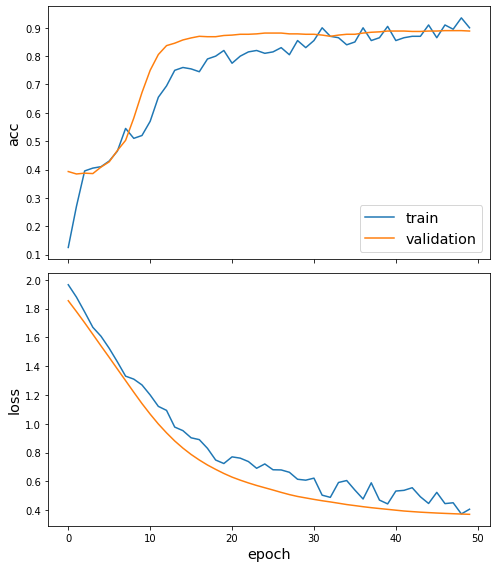

In [13]:
sg.utils.plot_history(history)

### Prediction:

In [14]:
# Loading the model: 

gat_model.load_weights("logs/best_model.h5")


# Test Metrics:

test_metrics = gat_model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(gat_model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 38ms/step - loss: 0.4125 - acc: 0.8850

Test Set Metrics:
	loss: 0.4125
	acc: 0.8850


In [15]:
# predicting:

pred_gen = generator.flow(test_x)
predictions = gat_model.predict(pred_gen)

In [16]:
predicted_values  = label_binarizer.inverse_transform(predictions.squeeze())
predicted_values

array(['Genetic_Algorithms', 'Neural_Networks', 'Case_Based', ...,
       'Probabilistic_Methods', 'Neural_Networks', 'Neural_Networks'],
      dtype='<U22')

In [17]:
# Creating a dataframe with the predicted and the actual values

df = pd.DataFrame({"Predicted":predicted_values, "True":test_data["Class"]})
df

,Predicted,True
Id,,
33895,Genetic_Algorithms,Genetic_Algorithms
255628,Neural_Networks,Neural_Networks
1128407,Case_Based,Case_Based
648232,Neural_Networks,Neural_Networks
12238,Theory,Theory
...,...,...
1130653,Case_Based,Case_Based
1106671,Neural_Networks,Neural_Networks
74821,Probabilistic_Methods,Probabilistic_Methods


### Node Embeddings

###### Embedding layer

In [18]:
emb_layer = next(i for i in gat_model.layers if i.name.startswith("graph_attention"))
print("Embedding layer: {0}, output shpe: {1}".format(emb_layer.name, emb_layer.output_shape))

Embedding layer: graph_attention_sparse, output shpe: (1, 2708, 64)


###### Designing the model

In [19]:
embedding_model = Model(inputs=x_inp, outputs=emb_layer.output)

###### Predicting the embedding

In [20]:
emb = embedding_model.predict(pred_gen)
emb.shape

(1, 2708, 64)

### Dimensionality reduction

In [21]:
# Input and output for reduction:

X = emb.squeeze()
y = np.argmax(label_binarizer.transform(cora_content["Class"]), axis=1)

In [22]:
transform = TSNE

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(X), index=list(cora_graph.nodes()))
emb_transformed["label"] = y

# The size of the embedding is reduced to 2

### Clustering (K Means)

In [23]:
# Importing required libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import*
import random
from copy import deepcopy
from sklearn.cluster import KMeans
random.seed(0)

In [24]:
data = [(emb_transformed[0][i],emb_transformed[1][i]) for i in emb_transformed.index]
data

[(57.736248, 25.525679),
 (-3.1673715, -43.42377),
 (38.08235, -51.308586),
 (32.842464, -44.77688),
 (0.49625704, 66.9046),
 (0.62081236, 26.687302),
 (22.140963, -47.904797),
 (54.994247, 22.197643),
 (58.225327, 25.695272),
 (-22.827919, 2.4266927),
 (31.163559, 12.885593),
 (4.439062, -19.50211),
 (8.910284, 38.43418),
 (-11.491011, -37.07105),
 (55.008537, 23.429306),
 (35.63852, -4.5251365),
 (27.271578, -43.11885),
 (41.93597, 4.699764),
 (53.908535, 2.0378847),
 (12.6937275, 19.816326),
 (-26.322458, 10.613083),
 (36.7736, -46.442974),
 (-58.722828, 26.407633),
 (-1.0187371, 47.930286),
 (25.562014, -39.38204),
 (-27.354782, 9.922386),
 (62.476517, -5.4011292),
 (0.6974996, 40.285545),
 (42.588364, -1.8598685),
 (-7.341289, -25.60431),
 (-36.77507, -34.159508),
 (46.66145, 27.428988),
 (-38.366814, -43.777714),
 (56.611065, 19.463379),
 (31.70123, -53.62923),
 (30.941504, -53.974586),
 (58.50107, 18.539465),
 (-66.62432, -5.7393484),
 (-54.934875, 22.298868),
 (27.41431, -44.70

###### Elblow method

Used to determine the value of clusters (k)

In [25]:
distortions = []
for k in range(1, 100):
    print("Cluster: ", k)
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data)
    distortions.append(kmeanModel.inertia_)

Cluster:  1
Cluster:  2
Cluster:  3
Cluster:  4
Cluster:  5
Cluster:  6
Cluster:  7
Cluster:  8
Cluster:  9
Cluster:  10
Cluster:  11
Cluster:  12
Cluster:  13
Cluster:  14
Cluster:  15
Cluster:  16
Cluster:  17
Cluster:  18
Cluster:  19
Cluster:  20
Cluster:  21
Cluster:  22
Cluster:  23
Cluster:  24
Cluster:  25
Cluster:  26
Cluster:  27
Cluster:  28
Cluster:  29
Cluster:  30
Cluster:  31
Cluster:  32
Cluster:  33
Cluster:  34
Cluster:  35
Cluster:  36
Cluster:  37
Cluster:  38
Cluster:  39
Cluster:  40
Cluster:  41
Cluster:  42
Cluster:  43
Cluster:  44
Cluster:  45
Cluster:  46
Cluster:  47
Cluster:  48
Cluster:  49
Cluster:  50
Cluster:  51
Cluster:  52
Cluster:  53
Cluster:  54
Cluster:  55
Cluster:  56
Cluster:  57
Cluster:  58
Cluster:  59
Cluster:  60
Cluster:  61
Cluster:  62
Cluster:  63
Cluster:  64
Cluster:  65
Cluster:  66
Cluster:  67
Cluster:  68
Cluster:  69
Cluster:  70
Cluster:  71
Cluster:  72
Cluster:  73
Cluster:  74
Cluster:  75
Cluster:  76
Cluster:  77
Cluster:

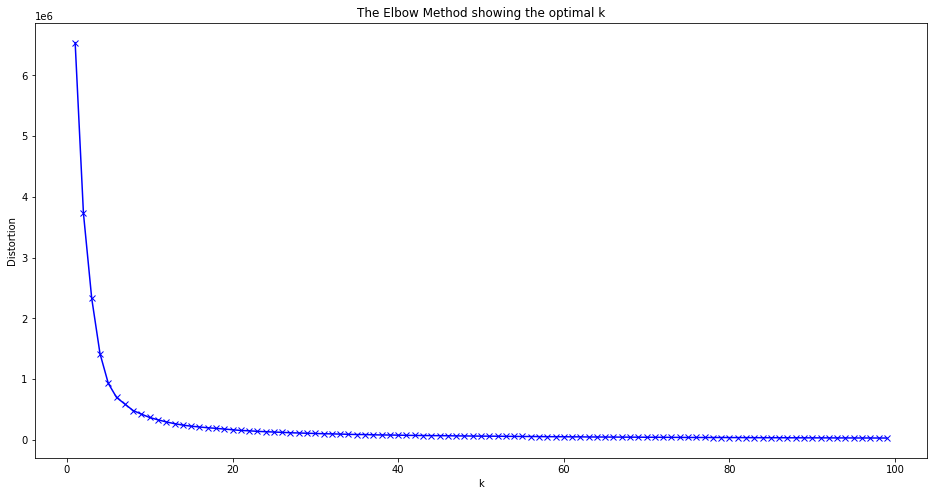

The elbow is around 5-12. So choosing the clustering value of 7


In [26]:
K = range(1,100)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

print("The elbow is around 5-12. So choosing the clustering value of 7")

###### Designing K means manually using the k value obtained via elbow method

In [27]:
# Splitting x and y in points

def points_to_list(data):
    X = []
    Y = []
    for i in data:
        X.append(i[0])
        Y.append(i[1])
    return X,Y

In [28]:
def euclidean_distance(x,y): # Calculating euclidean distance
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

In [47]:
# Finding the euclidean distance of all the elements in the clusters with the centeroid

def assign(data, centeroid, num_cluster):
    columns = []
    for i in range(num_cluster):
        columns.append(f"Distance_{i}")
    columns.append("Closest")
    columns.append("Points")
    
    X,Y = points_to_list(data)
    centeroid_X,centeroid_Y = points_to_list(centeroid)
    
    distance = []
    closest = []
    y = []
    for i in range(num_cluster):
        distance.append([])
        y.append((centeroid_X[i], centeroid_Y[i]))
    
    closest = []
    for inp in range(len(X)):
        x = X[inp],Y[inp]
        distance_list = []
        for i in range(num_cluster):
            distance[i].append(round(euclidean_distance(x,y[i]),2))
            
        for i in range(num_cluster):
            distance_list.append(distance[i][inp])
            
        closest.append(distance_list.index(min(distance_list))+1)
            
    updated_dataset = pd.DataFrame(columns=columns)
    updated_dataset["Points"] = data
    updated_dataset["Closest"] = closest
    for i in range(len(columns)):
        if columns[i] not in ["Closest", "Points"]:
            updated_dataset[columns[i]] = distance[i]
    
    return updated_dataset

In [59]:
def centeroid_calc(d,k):
    new_centeroids = []
    for i in range(k):
        points = list(d["Points"].where(d["Closest"]==i+1))
        points = [x for x in points if str(x) != 'nan']
        X,Y = points_to_list(points)
        m_x = int(np.mean(X))
        m_y = int(np.mean(Y))
        new_centeroids.append((m_x,m_y))
    return new_centeroids

###### K = 7

In [60]:
# Main function

# Calculation of new centeroid
k = 7
old_centeroid = [random.choice(data) for i in range(k)]
centeroid = old_centeroid.copy()

print("Given Centeroid: \n", centeroid)
while 1:
    updated_dataset = assign(data, centeroid, k)
    new_cent = centeroid_calc(updated_dataset, k)

    if centeroid != new_cent:
        centeroid = new_cent
        continue
    else:
        print("\n")
        print("New Centeroid: \n",centeroid)
        break

Given Centeroid: 
 [(18.1051, -0.90963614), (-61.443283, 6.5654016), (-11.303251, -60.559956), (-60.076225, 0.7634489), (14.764263, -12.664182), (-5.8974156, -43.918266), (-22.746536, 10.242745)]


New Centeroid: 
 [(47, 3), (-62, 16), (-21, -39), (-19, 1), (29, -44), (2, -9), (2, 41)]


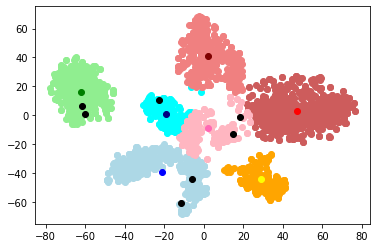

In [61]:
centeroid_X,centeroid_Y = points_to_list(centeroid)
old_centeroid_X,old_centeroid_Y = points_to_list(old_centeroid)
cluster_values = [i for i in updated_dataset["Closest"].values]

centeroid_color = {0:"red", 1:"g", 2:"blue", 3:"navy", 4:"yellow", 5:"hotpink", 6:"maroon"}
values_color = {1: "indianred", 2:"lightgreen", 3:"lightblue", 4:"cyan", 5:"orange", 6:"lightpink", 7:"lightcoral"}
for i in list(set(cluster_values)):
    points_list = list(updated_dataset["Points"].where(updated_dataset["Closest"] == i))
    points = [x for x in points_list if str(x) != 'nan']
    X, Y = points_to_list(points)
    plt.scatter(X,Y, color=values_color[i])
for i in range(len(centeroid_X)):
    plt.scatter(centeroid_X[i],centeroid_Y[i], color=centeroid_color[i])
    plt.scatter(old_centeroid_X[i], old_centeroid_Y[i], color="black")

###### K = 5

In [53]:
# Main function

k = 5
old_centeroid = [random.choice(data) for i in range(k)]
centeroid = old_centeroid.copy()

print("Given Centeroid: \n", centeroid)
while 1:
    updated_dataset = assign(data, centeroid, k)
    new_cent = centeroid_calc(updated_dataset, k)

    if centeroid != new_cent:
        centeroid = new_cent
        continue
    else:
        print("\n")
        print("New Centeroid: \n",centeroid)
        break

Given Centeroid: 
 [(-7.466087, -53.328377), (29.502398, -6.986509), (31.660566, 3.6882904), (35.591175, -3.2026434), (11.415734, -10.71301)]


New Centeroid: 
 [(-19, -17), (14, -46), (2, 40), (46, 3), (-62, 16)]


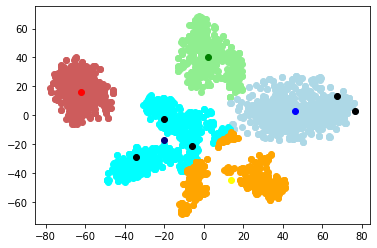

In [52]:
centeroid_X,centeroid_Y = points_to_list(centeroid)
old_centeroid_X,old_centeroid_Y = points_to_list(old_centeroid)
cluster_values = [i for i in updated_dataset["Closest"].values]

centeroid_color = {0:"red", 1:"g", 2:"blue", 3:"navy", 4:"yellow", 5:"hotpink", 6:"maroon"}
values_color = {1: "indianred", 2:"lightgreen", 3:"lightblue", 4:"cyan", 5:"orange", 6:"lightpink", 7:"lightcoral"}
for i in list(set(cluster_values)):
    points_list = list(updated_dataset["Points"].where(updated_dataset["Closest"] == i))
    points = [x for x in points_list if str(x) != 'nan']
    X, Y = points_to_list(points)
    plt.scatter(X,Y, color=values_color[i])
for i in range(len(centeroid_X)):
    plt.scatter(centeroid_X[i],centeroid_Y[i], color=centeroid_color[i])
    plt.scatter(old_centeroid_X[i], old_centeroid_Y[i], color="black")

###### K = 6

In [56]:
# Main function

k = 6
old_centeroid = [random.choice(data) for i in range(k)]
centeroid = old_centeroid.copy()

print("Given Centeroid: \n", centeroid)
while 1:
    updated_dataset = assign(data, centeroid, k)
    new_cent = centeroid_calc(updated_dataset, k)

    if centeroid != new_cent:
        centeroid = new_cent
        continue
    else:
        print("\n")
        print("New Centeroid: \n",centeroid)
        break

Given Centeroid: 
 [(50.010357, 7.982619), (-11.915392, 33.599106), (0.49625704, 66.9046), (11.948902, 27.18639), (8.060543, -17.677485), (-23.36945, 5.5433974)]


New Centeroid: 
 [(51, 4), (16, 0), (1, 42), (-23, -19), (14, -47), (-62, 16)]


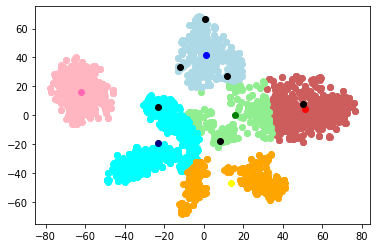

In [57]:
centeroid_X,centeroid_Y = points_to_list(centeroid)
old_centeroid_X,old_centeroid_Y = points_to_list(old_centeroid)
cluster_values = [i for i in updated_dataset["Closest"].values]

centeroid_color = {0:"red", 1:"g", 2:"blue", 3:"navy", 4:"yellow", 5:"hotpink", 6:"maroon"}
values_color = {1: "indianred", 2:"lightgreen", 3:"lightblue", 4:"cyan", 5:"orange", 6:"lightpink", 7:"lightcoral"}
for i in list(set(cluster_values)):
    points_list = list(updated_dataset["Points"].where(updated_dataset["Closest"] == i))
    points = [x for x in points_list if str(x) != 'nan']
    X, Y = points_to_list(points)
    plt.scatter(X,Y, color=values_color[i])
for i in range(len(centeroid_X)):
    plt.scatter(centeroid_X[i],centeroid_Y[i], color=centeroid_color[i])
    plt.scatter(old_centeroid_X[i], old_centeroid_Y[i], color="black")

###### k = 8

In [65]:
# Main function

k = 8
old_centeroid = [random.choice(data) for i in range(k)]
centeroid = old_centeroid.copy()

print("Given Centeroid: \n", centeroid)
while 1:
    updated_dataset = assign(data, centeroid, k)
    new_cent = centeroid_calc(updated_dataset, k)

    if centeroid != new_cent:
        centeroid = new_cent
        continue
    else:
        print("\n")
        print("New Centeroid: \n",centeroid)
        break

Given Centeroid: 
 [(38.117016, -54.688), (-8.857999, -37.693027), (-65.45702, -4.7436724), (26.813372, -45.277466), (16.80873, 29.089493), (13.856475, 26.089876), (-61.89252, 32.06687), (-4.5866957, -55.25539)]


New Centeroid: 
 [(29, -44), (-32, -33), (-13, -2), (28, 1), (56, 4), (2, 42), (-62, 16), (-5, -46)]


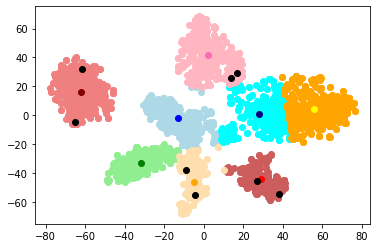

In [66]:
centeroid_X,centeroid_Y = points_to_list(centeroid)
old_centeroid_X,old_centeroid_Y = points_to_list(old_centeroid)
cluster_values = [i for i in updated_dataset["Closest"].values]

centeroid_color = {0:"red", 1:"g", 2:"blue", 3:"navy", 4:"yellow", 5:"hotpink", 6:"maroon", 7:"orange"}
values_color = {1: "indianred", 2:"lightgreen", 3:"lightblue", 4:"cyan", 5:"orange", 6:"lightpink", 7:"lightcoral", 8:"navajowhite"}
for i in list(set(cluster_values)):
    points_list = list(updated_dataset["Points"].where(updated_dataset["Closest"] == i))
    points = [x for x in points_list if str(x) != 'nan']
    X, Y = points_to_list(points)
    plt.scatter(X,Y, color=values_color[i])
for i in range(len(centeroid_X)):
    plt.scatter(centeroid_X[i],centeroid_Y[i], color=centeroid_color[i])
    plt.scatter(old_centeroid_X[i], old_centeroid_Y[i], color="black")

###### k = 9

In [67]:
# Main function

k = 9
old_centeroid = [random.choice(data) for i in range(k)]
centeroid = old_centeroid.copy()

print("Given Centeroid: \n", centeroid)
while 1:
    updated_dataset = assign(data, centeroid, k)
    new_cent = centeroid_calc(updated_dataset, k)

    if centeroid != new_cent:
        centeroid = new_cent
        continue
    else:
        print("\n")
        print("New Centeroid: \n",centeroid)
        break

Given Centeroid: 
 [(67.30998, 9.556273), (-63.565586, 8.151438), (-4.484356, 33.11544), (32.173946, -39.607388), (-68.36358, 10.239739), (56.86256, 1.8460176), (-14.382788, -11.524621), (30.257608, -41.16249), (-5.3944745, -27.13685)]


New Centeroid: 
 [(58, 5), (-60, 7), (2, 41), (0, -14), (-64, 25), (33, 2), (-18, 1), (29, -44), (-21, -39)]


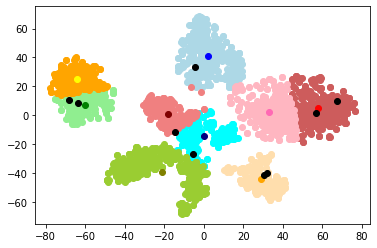

In [69]:
centeroid_X,centeroid_Y = points_to_list(centeroid)
old_centeroid_X,old_centeroid_Y = points_to_list(old_centeroid)
cluster_values = [i for i in updated_dataset["Closest"].values]

centeroid_color = {0:"red", 1:"g", 2:"blue", 3:"navy", 4:"yellow", 5:"hotpink", 6:"maroon", 7:"orange", 8:"olive"}
values_color = {1: "indianred", 2:"lightgreen", 3:"lightblue", 4:"cyan", 5:"orange", 6:"lightpink", 7:"lightcoral", 8:"navajowhite", 9:"yellowgreen"}
for i in list(set(cluster_values)):
    points_list = list(updated_dataset["Points"].where(updated_dataset["Closest"] == i))
    points = [x for x in points_list if str(x) != 'nan']
    X, Y = points_to_list(points)
    plt.scatter(X,Y, color=values_color[i])
for i in range(len(centeroid_X)):
    plt.scatter(centeroid_X[i],centeroid_Y[i], color=centeroid_color[i])
    plt.scatter(old_centeroid_X[i], old_centeroid_Y[i], color="black")

In [1]:
import random

In [7]:
random.seed(0)
print(random.random())

0.8444218515250481


In [10]:
random.seed(4)
print(random.random())

0.23604808973743452


In [14]:
print(random.random())

0.06651509567958991
